# Base CTP

* date

* country
* country_code
* country_id

* continent
* region -- sub-contintent but larger than country

* new_cases
* new_deaths
* new_tests



In [1]:
from datetime import date, datetime, timedelta


import pandas as pd
import numpy as np

from loguru import logger
import pycountry
from matplotlib.pylab import plt

%matplotlib inline

# Params 

In [2]:
ctp_dataset = 'https://covidtracking.com/api/v1/states/daily.csv'

base_ctp_dataset = '../../data/base_ctp.pkl'

# The columns used in the base representation
base_cols = [
    'date', 'state', 'state_code', 'country', 'country_code', 'country_id', 'continent', 'region', 
    'new_cases', 'new_deaths', 
    'population'
]

# The Covid Tracking Project Dataset

## Prepare the CTP Dataset 

In [3]:
logger.info('Loading CTP dataset @ %s' % ctp_dataset)

ctp = pd.read_csv(ctp_dataset, parse_dates=['date'], low_memory=False)
ctp.shape

2020-08-27 11:14:18.379 | INFO     | __main__:<module>:1 - Loading CTP dataset @ https://covidtracking.com/api/v1/states/daily.csv


(9785, 54)

In [4]:
ctp.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,2020-08-26,AK,5719.0,329085.0,NaN,44.0,NaN,NaN,NaN,6.0,...,334804,1,0,d9f7e0826fb6675334cd2621a69a85060d3df87d,0,0,0,0,0,NaN
1,2020-08-26,AL,119254.0,824431.0,NaN,1077.0,14005.0,NaN,1412.0,NaN,...,943685,8,212,d3485886905948f2a1ee44e033157877576c0571,0,0,0,0,0,NaN
2,2020-08-26,AR,58023.0,625250.0,NaN,435.0,4061.0,NaN,NaN,108.0,...,683273,21,48,7baca8490439947b97cb5779289239e087ab37f4,0,0,0,0,0,NaN
3,2020-08-26,AS,0.0,1514.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1514,0,0,d6804c7b3b61d39816426beba31ff5ca4758b98c,0,0,0,0,0,NaN
4,2020-08-26,AZ,199459.0,967451.0,NaN,967.0,21376.0,305.0,NaN,180.0,...,1166910,104,11,836897c2325e26019a8947a3eb09ac383976e40e,0,0,0,0,0,NaN


In [5]:
ctp.shape, ctp.state.nunique(), ctp.columns

((9785, 54),
 56,
 Index(['date', 'state', 'positive', 'negative', 'pending',
        'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
        'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
        'recovered', 'dataQualityGrade', 'lastUpdateEt', 'dateModified',
        'checkTimeEt', 'death', 'hospitalized', 'dateChecked',
        'totalTestsViral', 'positiveTestsViral', 'negativeTestsViral',
        'positiveCasesViral', 'deathConfirmed', 'deathProbable',
        'totalTestEncountersViral', 'totalTestsPeopleViral',
        'totalTestsAntibody', 'positiveTestsAntibody', 'negativeTestsAntibody',
        'totalTestsPeopleAntibody', 'positiveTestsPeopleAntibody',
        'negativeTestsPeopleAntibody', 'totalTestsPeopleAntigen',
        'positiveTestsPeopleAntigen', 'totalTestsAntigen',
        'positiveTestsAntigen', 'fips', 'positiveIncrease', 'negativeIncrease',
        'total', 'totalTestResultsSource', 'totalTestResults',
        'totalTestR

In [6]:
ctp = ctp.rename(columns={
    'positive': 'total_cases',
    'death': 'total_deaths',
    'state': 'state_code',
})[['date', 'total_cases', 'total_deaths', 'state_code']].set_index('state_code')

ctp.shape, ctp.date.max()

((9785, 3), Timestamp('2020-08-26 00:00:00'))

## Get State Populations and Codes

In [7]:
logger.info('Loading population data dataset @ %s' % 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv')

pops = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv', low_memory=False)

pops = pops.rename(columns={
    'NAME': 'state',
    'POPESTIMATE2019': 'population'
})[['state', 'population']].set_index('state')

pops.head()

2020-08-27 11:14:20.693 | INFO     | __main__:<module>:1 - Loading population data dataset @ https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/state/detail/SCPRC-EST2019-18+POP-RES.csv


,population
state,
United States,328239523
Alabama,4903185
Alaska,731545
Arizona,7278717
Arkansas,3017804


In [8]:
logger.info('Loading country codes data dataset @ %s' % 'https://worldpopulationreview.com/states/state-abbreviations')

states = pd.read_html('https://worldpopulationreview.com/states/state-abbreviations')[0]

states = states.rename(columns={
    'State': 'state',
    'Code': 'state_code'
})[['state', 'state_code']].set_index('state')

states.head()

2020-08-27 11:14:21.168 | INFO     | __main__:<module>:1 - Loading country codes data dataset @ https://worldpopulationreview.com/states/state-abbreviations


,state_code
state,
Alabama,AL
Alaska,AK
Arizona,AZ
Arkansas,AR
California,CA


## Add the state names and populations

In [9]:
ctp = ctp.join(states.join(pops).reset_index().set_index('state_code')).reset_index().dropna(subset=['state', 'state_code'])

ctp['state_code'].nunique()

51

In [10]:
ctp = ctp.sort_values(by='date')
ctp.tail()

,state_code,date,total_cases,total_deaths,state,population
4336,MN,2020-08-26,71236.0,1842.0,Minnesota,5639632.0
6617,OH,2020-08-26,117584.0,4044.0,Ohio,11689100.0
6441,NY,2020-08-26,431340.0,25305.0,New York,19453561.0
9438,WV,2020-08-26,9540.0,190.0,West Virginia,1792147.0
0,AK,2020-08-26,5719.0,37.0,Alaska,731545.0


# New Cases/Deaths

In [11]:
new_cases_deaths = ctp.groupby('state_code').apply(
    lambda g: g.set_index('date')[['total_cases', 'total_deaths']]\
        .diff()\
        .fillna(g.set_index('date')[['total_cases', 'total_deaths']])).rename(columns={
    'total_cases': 'new_cases',
    'total_deaths': 'new_deaths'
})

ctp = ctp.set_index(['state_code', 'date']).join(new_cases_deaths).reset_index()

ctp.tail()

,state_code,date,total_cases,total_deaths,state,population,new_cases,new_deaths
8960,MN,2020-08-26,71236.0,1842.0,Minnesota,5639632.0,529.0,17.0
8961,OH,2020-08-26,117584.0,4044.0,Ohio,11689100.0,1089.0,48.0
8962,NY,2020-08-26,431340.0,25305.0,New York,19453561.0,566.0,8.0
8963,WV,2020-08-26,9540.0,190.0,West Virginia,1792147.0,145.0,3.0
8964,AK,2020-08-26,5719.0,37.0,Alaska,731545.0,53.0,1.0


# Save Dataset

In [12]:
ctp['country'] = 'United States'
ctp['country_code'] = 'USA'
ctp['country_id'] = 'US'
ctp['continent'] = 'North America'
ctp['region'] = 'northern_america'

In [13]:
ctp_base = ctp[base_cols].copy()
ctp_base.shape, ctp_base['country'].nunique()

((8965, 11), 1)

In [14]:
# [ctp_base.fillna(0, inplace=True) for col in ctp_base.filter(like='new_')]

# assert ctp_base.notnull().all().all()

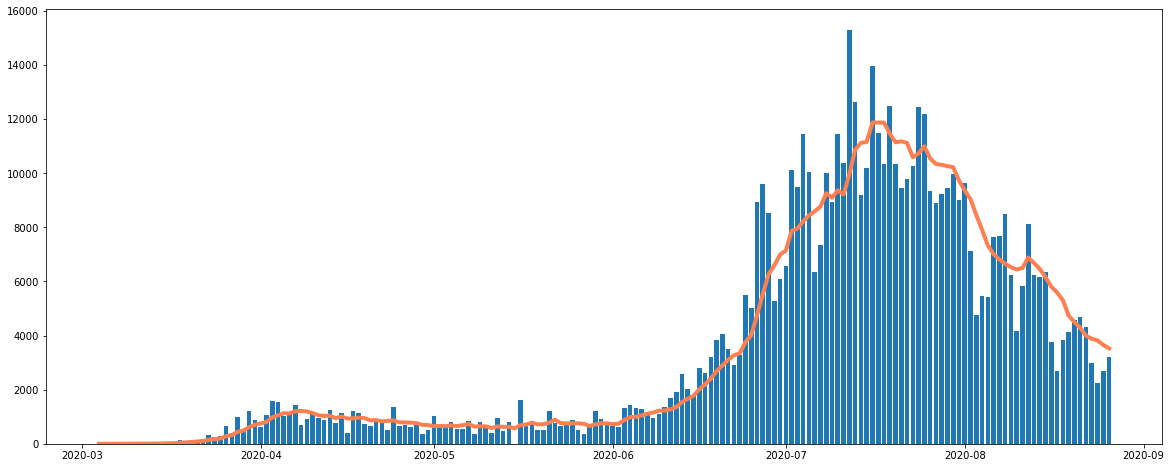

In [15]:
fig, ax = plt.subplots(figsize=(20, 8))

state = 'Florida'
x = ctp_base[ctp_base['state']==state].set_index('date').index
y = ctp_base[ctp_base['state']==state].set_index('date')['new_cases']

ax.bar(x, y)
ax.plot(x, y.rolling('7d').mean(), c='coral', lw=4)

In [16]:
logger.info('Saving base CTP dataset --> %s' % base_ctp_dataset)

ctp_base.to_pickle(base_ctp_dataset)
ctp_base.shape, ctp_base.date.max()

2020-08-27 11:14:22.773 | INFO     | __main__:<module>:1 - Saving base CTP dataset --> ../../data/base_ctp.pkl


((8965, 11), Timestamp('2020-08-26 00:00:00'))